In [1]:
# 加载画图包
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
from legendkit import legend

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
import sys
sys.path.append('/public1/mowp/workspace/nanopore_modification/scripts/')
%aimport metaplot
%aimport utils

In [4]:
import numpy as np
import pandas as pd
from pybedtools import BedTool
from concurrent.futures import ProcessPoolExecutor
import pysam
from multiprocessing import cpu_count
import math
from itertools import repeat
import pyBigWig
from collections import Counter

In [5]:
infiles = {
    'wt1029':[
        '/data/Zhaijx/mowp/data/read_until/20221029_col_m6A/6ma_results/20221029_col_m6A.6mA_genome_pos.tsv.gz',
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/col_PEK/20221029_col_m6A.5mC_genome_pos.tsv.gz',
    ],
}

In [5]:
bw_files = {
    'wt1029':[
        '/data/Zhaijx/mowp/data/read_until/20221029_col_m6A/6ma_results/bw_files/20221029_col_m6A.6mA.q2.1kb.bw',
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/col_PEK/5mc_results/frequency/20221029_col_m6A.C.call_mods.frequency.CG.bw'],
}

In [7]:
bamfiles = {
    'wt1029': '/data/Zhaijx/mowp/data/read_until/20221029_col_m6A/aligned_data/20221029_col_m6A.sorted.q2.bam',
}

# 45s rDNA

In [6]:
infile = '/data/Zhaijx/mowp/db/col-PEK/bed/Col-PEK1.5_45S-subunitsrRNA.bed.gz'
rdna = BedTool(infile)

infile = '/data/Zhaijx/mowp/db/col-PEK/45s/45s_rRNA_var_PEK.sorted.bed'
infile = '/data/Zhaijx/mowp/db/col-PEK/45s/45s_rRNA_var_PEK.bed'
rdna_var = BedTool(infile)

In [7]:
rdna_var = rdna.intersect(rdna_var, wa=True, wb=True)
var_dict = {}
for item in rdna_var:
    var_id = item[15]
    chrom, start, end, strand = item[0], int(item[1]), int(item[2]), item[5]
    if var_id not in var_dict:
        var_dict[var_id] = []
    var_dict[var_id].append((chrom, start, end, strand))

In [8]:

def get_methy_ratio(infile, chrom, start, end, fully_span=False, read_set=None, max_sites=10):
    tbx = pysam.TabixFile(infile)
    methy_ratio = []
    for line in tbx.fetch(chrom, start, end):
        read_id, mod, _chrom, _start, _end, strand, methylated_pos, unmethylated_pos = line.split('\t')
        _start, _end = int(_start), int(_end)

        if fully_span and not(_start <= start and _end > end):
            continue
        if read_set is not None and read_id not in read_set:
            continue

        methylated_pos = np.fromstring(methylated_pos, sep=',', dtype=int)
        unmethylated_pos = np.fromstring(unmethylated_pos, sep=',', dtype=int)
        _methylated_pos = methylated_pos[((methylated_pos >= start) & (methylated_pos <= end))]
        _unmethylated_pos = unmethylated_pos[((unmethylated_pos >= start) & (unmethylated_pos <= end))]

        try:
            _methy_ratio = len(_methylated_pos) / (len(_methylated_pos) + len(_unmethylated_pos))
            if len(methylated_pos) + len(unmethylated_pos) >= max_sites:
                methy_ratio.append(_methy_ratio)
        except ZeroDivisionError:
            continue
    
    read_n = len(methy_ratio)
    if read_n > 3:
        methy_ratio = np.mean(methy_ratio)
    else:
        methy_ratio = np.nan
    
    return chrom, start, end, methy_ratio, read_n

In [9]:
def get_methy_ratio_turbo(infile, pos_list, fully_span=False, read_set=None, max_sites=10, threads=1):
    pos_list = np.array(pos_list)
    chroms = pos_list[:, 0]
    starts = pos_list[:, 1].astype('int')
    ends = pos_list[:, 2].astype('int')
    
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = math.ceil(len(starts) / threads)
        results = e.map(
            get_methy_ratio,
            repeat(infile),
            chroms, starts, ends,
            repeat(fully_span), repeat(read_set), repeat(max_sites),
            chunksize=chunksize)
    
    return list(results)

In [10]:
def get_bigwig_average_value(infile, chrom, start, end):
    bw = pyBigWig.open(infile)
    values = bw.values(chrom, start, end)
    bw.close()
    values = np.array(values)
    values = values[~np.isnan(values)]
    if len(values) > 0:
        return chrom, start, end, np.mean(values)
    else:
        return chrom, start, end, np.nan


In [11]:
def get_bigwig_average_value_turbo(infile, pos_list, threads=1):
    pos_list = np.array(pos_list)
    chroms = pos_list[:, 0]
    starts = pos_list[:, 1].astype('int')
    ends = pos_list[:, 2].astype('int')
    
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = math.ceil(len(starts) / threads)
        results = e.map(
            get_bigwig_average_value,
            repeat(infile),
            chroms, starts, ends,
            chunksize=chunksize)
    
    return list(results)

# All variants

In [12]:
# multi run CG

name = 'wt1029'

infile = bw_files[name][1]
results = None
for var_id in ('VAR1', 'VAR2', 'VAR3'):
    pos_list = var_dict[var_id]
    threads = cpu_count()

    wt_results = get_bigwig_average_value_turbo(infile, pos_list, threads=threads)
    wt_results = pd.DataFrame(wt_results, columns=['chrom', 'start', 'end', 'ratio'])
    wt_results['var'] = var_id
    if results is None:
        results = wt_results
    else:
        results = pd.concat([results, wt_results])

In [13]:
wt_cg_results = results

In [14]:
# multi run 6mA

name = 'wt1029'

infile = bw_files[name][0]
results = None
for var_id in ('VAR1', 'VAR2', 'VAR3'):
    pos_list = var_dict[var_id]
    threads = cpu_count()

    wt_results = get_bigwig_average_value_turbo(infile, pos_list, threads=threads)
    wt_results = pd.DataFrame(wt_results, columns=['chrom', 'start', 'end', 'ratio'])
    wt_results['var'] = var_id
    if results is None:
        results = wt_results
    else:
        results = pd.concat([results, wt_results])

In [15]:
wt_6ma_results = results
wt_6ma_results['ratio'] = wt_6ma_results['ratio'] / 100

In [16]:
data = pd.merge(wt_6ma_results, wt_cg_results, on=['chrom', 'start', 'end', 'var'], suffixes=['_6ma', '_cg'])

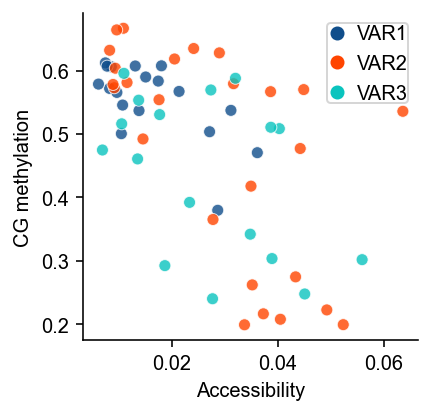

In [18]:
plt.figure(figsize=(3, 3))
sns.scatterplot(
    data=data, x='ratio_6ma', y='ratio_cg', hue='var', palette=['#104e8b', '#ff4500', '#0ac4be'], alpha=.8)

plt.xlabel('Accessibility')
plt.ylabel('CG methylation')
plt.legend(title="", frameon=True)

sns.despine()